# Importing libraries and initialising data


In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


In [2]:
print(tf.__version__)

2.10.0


## Getting train and testing data

In [3]:
(x_train, y_train), (x_rem, y_rem) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


(None, None)

# Problem Statement

## Implement an image classifier using a deep learning network. 

### X_train and x_test are 28x28 images of fashion items. The y_train and y_test are the labels for the images. 
The labels are integers from 0 to 9. The labels are as follows:
List of labels
| Label       | Description |
| ----------- | ----------- |
| 0           | T-shirt/Top |
| 1           | Trouser     |
| 2           | Pullover    |
| 3           | Dress       |
| 4           | Coat        |
| 5           | Sandal      |
| 6           | Shirt       |
| 7           | Sneaker     |
| 8           | Bag         |
| 9           | Ankle Boot  |


Image dimmensions are 28x28.

The train set and test set are given in two separate datasets.

# What are neural networks?
![backprop](../Images/Backpropagation.gif)
![mnist](../Images/neuralwork.gif)
## Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another.

# EDA

## Distribution of Data

In [5]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(pd.DataFrame(y_train, columns=["label"]))

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


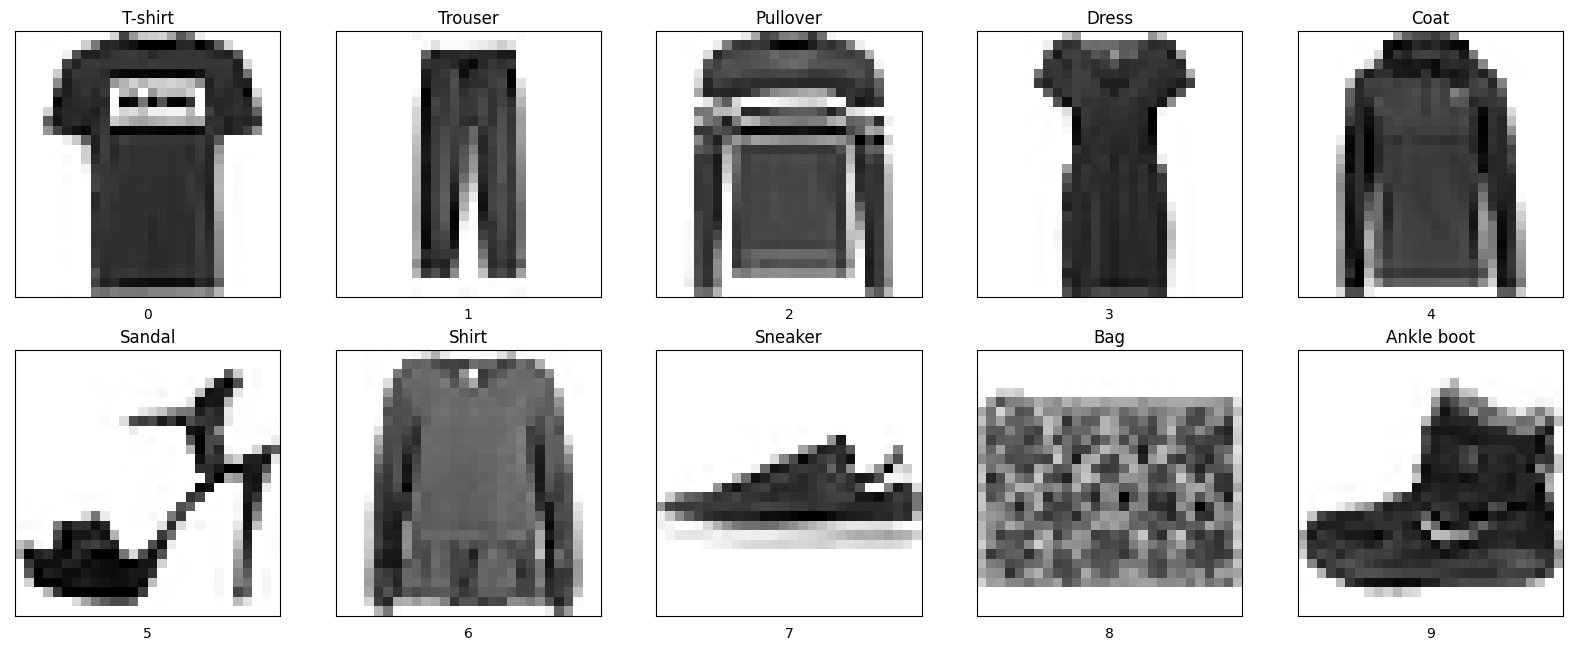

In [6]:
array_of_each_class_position = [1,21,5,20,24,9,18,6,23,0]
# plot all images in array_of_each_class_position
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[i])
    plt.imshow(tf.keras.datasets.fashion_mnist.load_data()[0][0][array_of_each_class_position[i]], cmap=plt.cm.binary)
    plt.xlabel(tf.keras.datasets.fashion_mnist.load_data()[0][1][array_of_each_class_position[i]])
plt.show()

## Normalizing the data

In [7]:
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

# Definition collection

In [18]:
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from keras.models import load_model
import visualkeras
from PIL import ImageFont
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename=f'accuracy-loss_{train_model}')
    
def plot_graph(model_name):
    score = model_name.model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    accuracy = model_name.history['accuracy']
    val_accuracy = model_name.history['val_accuracy']
    loss = model_name.history['loss']
    val_loss = model_name.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def print_classification(model_hdf5):

    #locate index of '1' in each row
    cnn_best = load_model(model_hdf5)
    #Confirm loss and accuracy on the test data
    cnn_best.evaluate(x_test,y_test)
    #get the predictions for the test data
    preds = cnn_best.predict(x_test)
    preds = np.argmax(np.round(preds),axis=1)
    print(preds)

    #outputing as classifcation matrix to see the accuracy of each class

    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    #get the indices to be plotted
    correct = np.nonzero(preds==y_test)[0]
    incorrect = np.nonzero(preds!=y_test)[0]
    target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
    print(classification_report(y_test, preds, target_names=target_names))
 
def visualise_keras(model,number):

    visualkeras.layered_view(model).show()
    visualkeras.layered_view(model, to_file=f'output{number}.png')
    font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
    visualkeras.layered_view(model, legend=True, font=font)  # font is optional!
    # baseline cnn model for fashion mnist



# evaluate a model using k-fold cross-validation
def evaluate_model(model,dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		h_callback = EarlyStopping(monitor='val_loss', patience=5)
		# fit model
		history = model.fit(trainX, trainY, epochs=50, validation_data=(testX, testY), verbose=1,callbacks=[h_callback], batch_size=256) 
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		pyplot.legend()
	pyplot.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# run the test harness for evaluating a model
def run_test_harness(model,X_train, y_train):
	# evaluate model
	scores, histories = evaluate_model(model,X_train, y_train)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)


# Info for building models

The Sequential model is a linear stack of layers. It can be first initialized and then we add layers using add method or we can add all layers at init stage. The layers added are as follows:

Conv2D is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:

filters - the number of filters (Kernels) used with this layer; here filters = 32;
kernel_size - the dimmension of the Kernel: (3 x 3);
activation - is the activation function used, in this case relu;
kernel_initializer - the function used for initializing the kernel;
input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28 The input and output of the Conv2D is a 4D tensor.
MaxPooling2D is a Max pooling operation for spatial data. Parameters used here are:

pool_size, in this case (2,2), representing the factors by which to downscale in both directions;

Conv2D with the following parameters:

filters: 64;
kernel_size : (3 x 3);
activation : relu;
MaxPooling2D with parameter:

pool_size : (2,2);
Conv2D with the following parameters:

filters: 128;
kernel_size : (3 x 3);
activation : relu;
Flatten. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

Dense. This layer is a regular fully-connected NN layer. It is used without parameters;

units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
activation - activation function : relu;
Dense. This is the final layer (fully connected). It is used with the parameters:

units: the number of classes (in our case 10);
activation : softmax; for this final layer it is used softmax activation (standard for multiclass classification)
Then we compile the model, specifying as well the following parameters:

In [8]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout , BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 1 - Basic CNN (Stupid baseline)

In [9]:
# reshape dataset to have a single channel
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.fit(x_train,y_train , epochs=10)

model.summary()

Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.4965 - accuracy: 0.8246
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3719 - accuracy: 0.8658
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3340 - accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3099 - accuracy: 0.8867
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2913 - accuracy: 0.8932
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2777 - accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2655 - accuracy: 0.9018
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2565 - accuracy: 0.9044
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2445 - accuracy: 0.9089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.236

# Model 2 - Adding more layers

## Trying out with batch normalization/dropout

In [13]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
model_2.add(Dropout(0.2))
model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
model_2.add(Dropout(0.4))
model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(10, activation='softmax'))

model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 24)        6936      
                                                      

In [14]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('best_model2_DO_BN.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [15]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Epoch 1/50
235/235 [==============================] - 21s 47ms/step - loss: 0.8186 - accuracy: 0.7162 - val_loss: 1.5511 - val_accuracy: 0.8414
Epoch 2/50
235/235 [==============================] - 10s 41ms/step - loss: 0.4419 - accuracy: 0.8412 - val_loss: 0.7131 - val_accuracy: 0.8754
Epoch 3/50
235/235 [==============================] - 10s 41ms/step - loss: 0.3886 - accuracy: 0.8593 - val_loss: 0.3330 - val_accuracy: 0.8886
Epoch 4/50
235/235 [==============================] - 8s 33ms/step - loss: 0.3529 - accuracy: 0.8725 - val_loss: 0.2940 - val_accuracy: 0.8944
Epoch 5/50
235/235 [==============================] - 7s 30ms/step - loss: 0.3253 - accuracy: 0.8816 - val_loss: 0.2629 - val_accuracy: 0.9028
Epoch 6/50
235/235 [==============================] - 7s 30ms/step - loss: 0.3066 - accuracy: 0.8881 - val_loss: 0.2622 - val_accuracy: 0.9130
Epoch 7/50
235/235 [==============================] - 8s 32ms/step - loss: 0.2915 - accuracy: 0.8948 - val_loss: 0.2473 - val_accuracy: 0.9

In [16]:
visualise_keras(model_2,1)

### Visualising model performance

In [17]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Test loss: 0.19295746088027954
Test accuracy: 0.9309999942779541


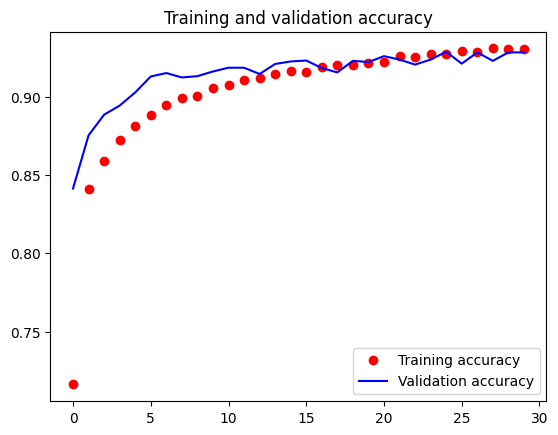

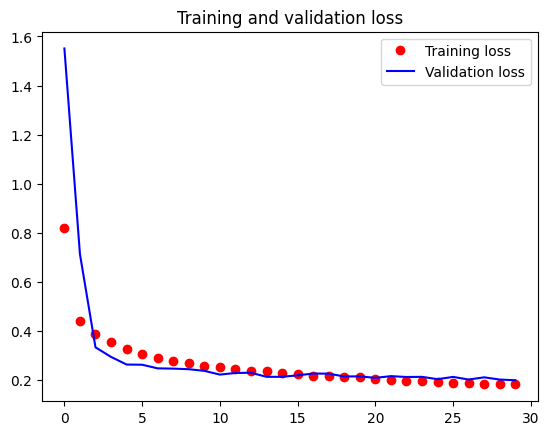

In [25]:
plot_graph(history)

### Model evaluation

In [28]:
print_classification('best_model2_DO_BN.hdf5')

157/157 [==============================] - 1s 5ms/step
[2 3 0 ... 0 6 4]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.76      0.93      0.84       524
    Item Trouser 1       1.00      0.98      0.99       506
   Item Pullover 2       0.91      0.88      0.89       496
      Item Dress 3       0.95      0.92      0.93       478
       Item Coat 4       0.90      0.87      0.89       488
     Item Sandal 5       0.98      0.99      0.99       525
      Item Shirt 6       0.84      0.75      0.80       486
    Item Sneaker 7       0.96      0.98      0.97       488
        Item Bag 8       0.99      0.99      0.99       516
 Item Ankle Boot 9       0.99      0.95      0.97       493

          accuracy                           0.93      5000
         macro avg       0.93      0.92      0.93      5000
      weighted avg       0.93      0.93      0.93      5000



## Trying out with Dropout Only

In [20]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size=(3, 3),
                activation='relu',
                kernel_initializer='he_normal',
                input_shape=(28,28,1)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
#loop through the optimizers
model_2.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
    

model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 64)         

In [21]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('best_model2_DO.hdf5', save_best_only = True)

In [22]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Epoch 1/50


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 5s 16ms/step - loss: 0.7654 - accuracy: 0.7157 - val_loss: 0.4735 - val_accuracy: 0.8340
Epoch 2/50
 41/235 [====>.........................] - ETA: 2s - loss: 0.5059 - accuracy: 0.8118

KeyboardInterrupt: 

### Visualising model performance

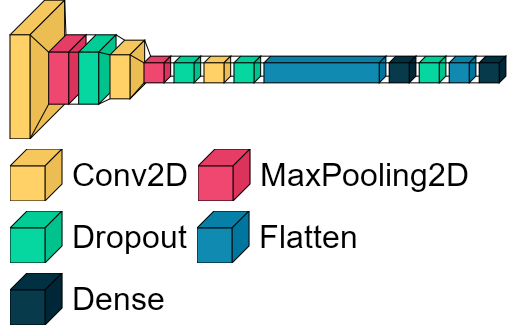

In [ ]:
visualise_keras(model_2,2)

In [ ]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



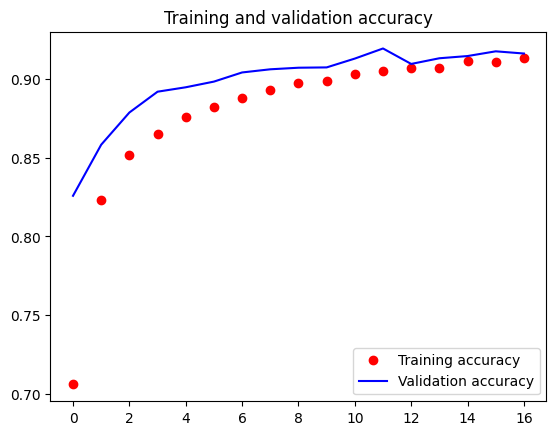

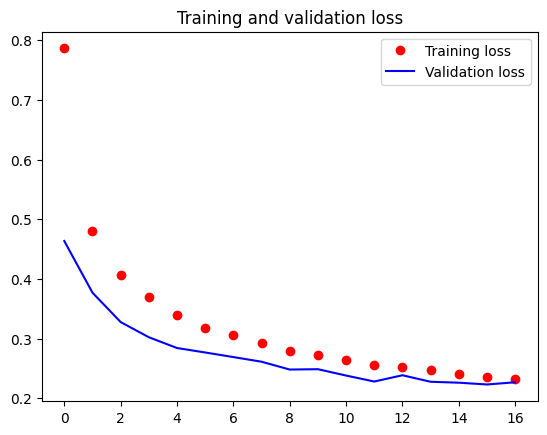

In [ ]:
plot_graph(history )

### Model Evaluation

### Showing performance based on predicted values

In [29]:
#locate index of '1' in each row
cnn_best = load_model('best_model2_DO.hdf5')
#Confirm loss and accuracy on the test data
cnn_best.evaluate(x_test,y_test)
#get the predictions for the test data
preds = cnn_best.predict(x_test)
preds = np.argmax(np.round(preds),axis=1)
print(preds)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 6ms/step
[0 3 0 ... 0 6 0]


In [30]:
from sklearn.metrics import classification_report
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(preds==y_test)[0]
incorrect = np.nonzero(preds!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.41      0.89      0.56       524
    Item Trouser 1       1.00      0.92      0.96       506
   Item Pullover 2       0.84      0.43      0.57       496
      Item Dress 3       0.87      0.85      0.86       478
       Item Coat 4       0.73      0.68      0.70       488
     Item Sandal 5       0.94      0.95      0.95       525
      Item Shirt 6       0.70      0.34      0.45       486
    Item Sneaker 7       0.90      0.92      0.91       488
        Item Bag 8       0.97      0.94      0.96       516
 Item Ankle Boot 9       0.96      0.91      0.93       493

          accuracy                           0.79      5000
         macro avg       0.83      0.78      0.79      5000
      weighted avg       0.83      0.79      0.79      5000



#### Correct predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_34792\3398885827.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



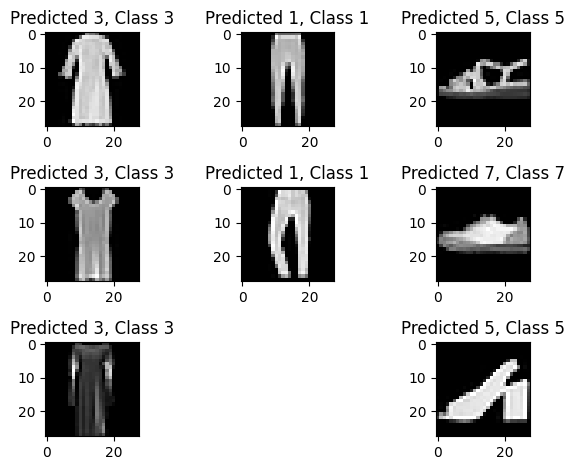

In [31]:
for i, correct_val in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(preds[correct_val], y_test[correct_val]))
    plt.tight_layout()

#### Incorrect predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_34792\398227340.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



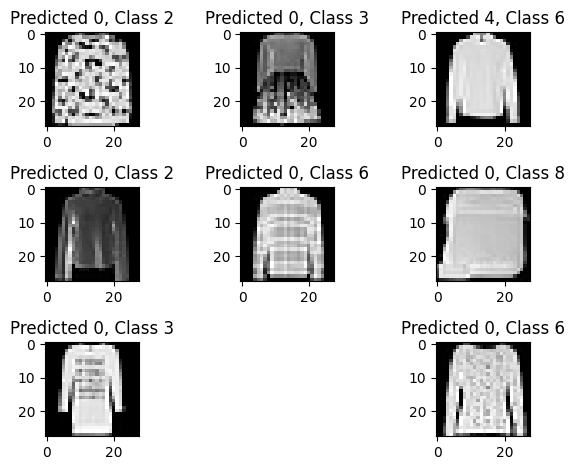

In [32]:
for i, incorrect_val in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(preds[incorrect_val], y_test[incorrect_val]))
    plt.tight_layout()

# Tuning Model 2 

## Trying out with data augmentation

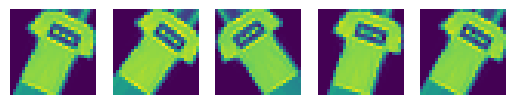

In [13]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,  
    zca_whitening=False,
    rotation_range=50,
    width_shift_range=0.01, 
    height_shift_range=0.01, 
    horizontal_flip=False, 
    vertical_flip=False)

datagen.fit(x_train)

from matplotlib import pyplot as plt

gen = datagen.flow(x_train[1:2], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

### Model 2 with dropout only

In [14]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model_2.add(MaxPooling2D((2, 2)))
    model_2.add(Dropout(0.25))
    model_2.add(Conv2D(64, (3, 3), activation='relu'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.25))
    model_2.add(Conv2D(128, (3, 3), activation='relu'))
    model_2.add(Dropout(0.4))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model_2.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
        
    model_2.summary()

    return model_2

In [15]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('data_aug_best_model2_DO.hdf5', save_best_only = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)         

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



188/188 [==============================] - 8s 28ms/step - loss: 0.8295 - accuracy: 0.6905 - val_loss: 0.5038 - val_accuracy: 0.8100
Epoch 2/50
188/188 [==============================] - 5s 25ms/step - loss: 0.5030 - accuracy: 0.8150 - val_loss: 0.4175 - val_accuracy: 0.8391
Epoch 3/50
188/188 [==============================] - 5s 26ms/step - loss: 0.4350 - accuracy: 0.8385 - val_loss: 0.3530 - val_accuracy: 0.8671
Epoch 4/50
188/188 [==============================] - 4s 23ms/step - loss: 0.3929 - accuracy: 0.8563 - val_loss: 0.3419 - val_accuracy: 0.8719
Epoch 5/50
188/188 [==============================] - 3s 17ms/step - loss: 0.3655 - accuracy: 0.8653 - val_loss: 0.3013 - val_accuracy: 0.8898
Epoch 6/50
188/188 [==============================] - 2s 13ms/step - loss: 0.3355 - accuracy: 0.8761 - val_loss: 0.2855 - val_accuracy: 0.8945
Epoch 7/50
188/188 [==============================] - 3s 18ms/step - loss: 0.3240 - accuracy: 0.8818 - val_loss: 0.2715 - val_accuracy: 0.8983
Epoch 8/50

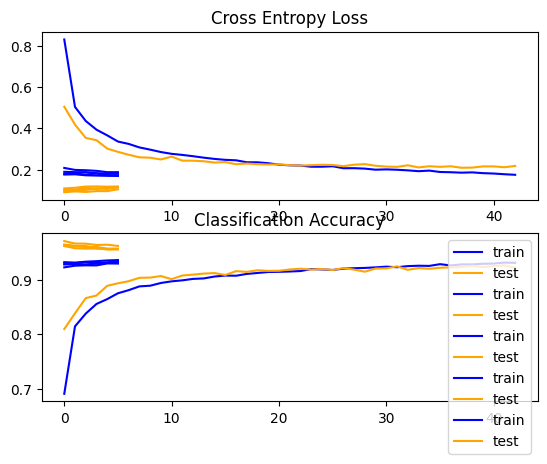

Accuracy: mean=95.192 std=1.460, n=5


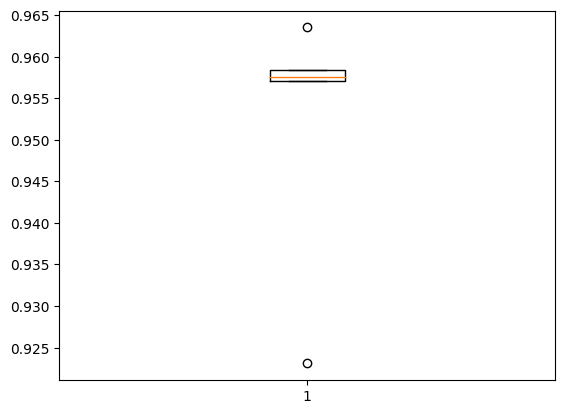

In [19]:
run_test_harness(model_2_create(),x_train,y_train)

In [ ]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
        epochs=50,  
        verbose=1,
        callbacks = [monitor_val_acc, model_checkpoint],
        validation_data = (x_valid, y_valid))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_95 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_96 (Dropout)        (None, 5, 5, 64)        

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 6s 16ms/step - loss: 0.7865 - accuracy: 0.7077 - val_loss: 0.4657 - val_accuracy: 0.8312
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4719 - accuracy: 0.8265 - val_loss: 0.3770 - val_accuracy: 0.8658
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4045 - accuracy: 0.8514 - val_loss: 0.3422 - val_accuracy: 0.8760
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.3661 - accuracy: 0.8663 - val_loss: 0.3221 - val_accuracy: 0.8836
Epoch 5/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3379 - accuracy: 0.8766 - val_loss: 0.2838 - val_accuracy: 0.8982
Epoch 6/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3198 - accuracy: 0.8822 - val_loss: 0.2743 - val_accuracy: 0.9018
Epoch 7/50
235/235 [==============================] - 2s 11ms/step - loss: 0.3032 - accuracy: 0.8887 - val_loss: 0.2622 - val_accuracy: 0.9050
Epoch 8/50

In [ ]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9182
Test accuracy: [0.23591265082359314, 0.9182000160217285]


#### Visualising model performance

Test loss: 0.23591265082359314
Test accuracy: 0.9182000160217285


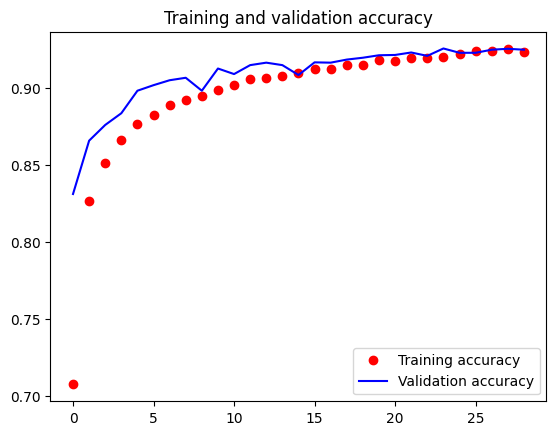

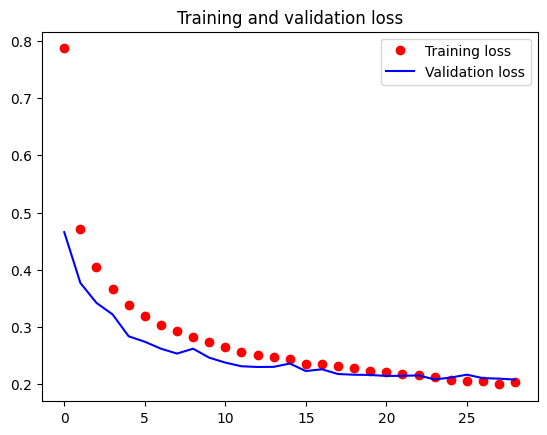

In [ ]:
plot_graph(model_2_data_augmented)

In [ ]:
plot_accuracy_and_loss(model_2_data_augmented)

#### Model Evaluation

In [34]:
print_classification('data_aug_best_model2_DO.hdf5')

 15/157 [=>............................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9479 

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 5ms/step
[2 3 3 ... 0 6 2]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.79      0.87      0.83       524
    Item Trouser 1       0.99      0.98      0.99       506
   Item Pullover 2       0.91      0.87      0.89       496
      Item Dress 3       0.95      0.92      0.94       478
       Item Coat 4       0.88      0.88      0.88       488
     Item Sandal 5       0.99      0.98      0.98       525
      Item Shirt 6       0.77      0.77      0.77       486
    Item Sneaker 7       0.94      0.98      0.96       488
        Item Bag 8       0.99      0.98      0.98       516
 Item Ankle Boot 9       0.98      0.95      0.97       493

          accuracy                           0.92      5000
         macro avg       0.92      0.92      0.92      5000
      weighted avg       0.92      0.92      0.92      5000



### Model 2 with batchnormalization and dropout

In [20]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [13]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('data_aug_best_model2_DO_BN.hdf5', save_best_only = True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_8 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout_9 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 24)        6936      
                                                      

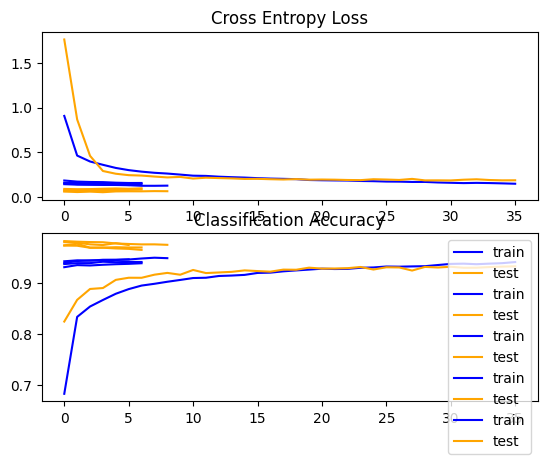

Accuracy: mean=96.390 std=1.570, n=5


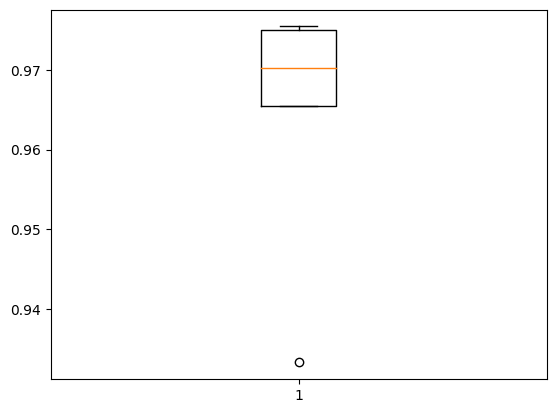

In [21]:
run_test_harness(model_2_create(),x_train,y_train)

In [ ]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_99 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_100 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 conv2d_80 (Conv2D)          (None, 28, 28, 24)        6936      
                                                     

#### Visualising model performance

In [ ]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 2s 15ms/step - loss: 0.2105 - accuracy: 0.9302
Test accuracy: [0.21045173704624176, 0.9301999807357788]


Test loss: 0.21045173704624176
Test accuracy: 0.9301999807357788


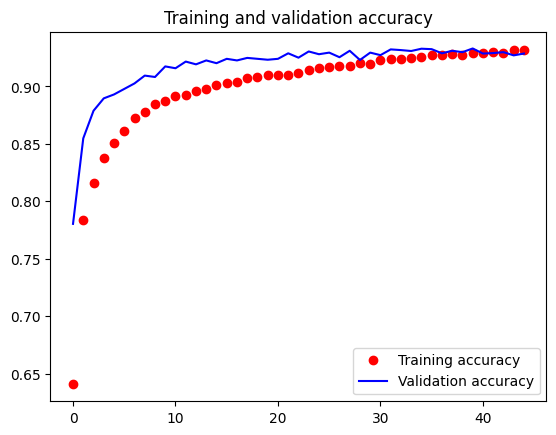

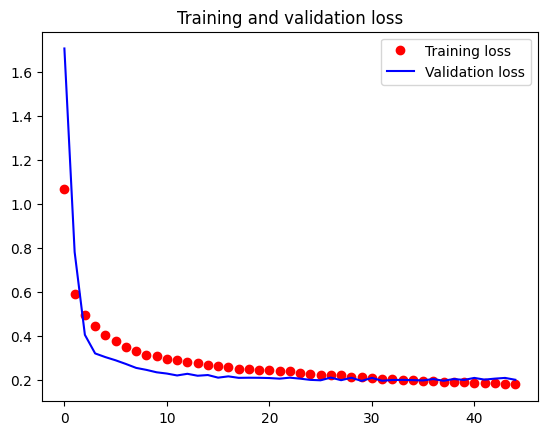

In [ ]:
plot_graph(model_2_data_augmented)

In [ ]:
plot_accuracy_and_loss(model_2_data_augmented)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### Model Evaluation

In [21]:
print_classification('data_aug_best_model2_DO_BN.hdf5')

TypeError: classification_report() missing 1 required positional argument: 'y_pred'

## Trying out with regularization/weigh decay

In [ ]:
#Get back original x_train,x_test,x_valid
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

(60000, 28, 28, 1)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


### Model 2 with dropout only

In [ ]:
from keras import regularizers
from keras.optimizers import Adam
def model_2_create():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',         
                    kernel_initializer='he_normal', 
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('regularizer_model_2_DO.hdf5', save_best_only = True)
# Early stop on validation accuracy     
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
run_test_harness(model_2_create(),x_train,y_train)

In [ ]:
history = model_2_create().fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Epoch 1/50
235/235 [==============================] - 5s 15ms/step - loss: 1.8492 - accuracy: 0.3636 - val_loss: 84.9894 - val_accuracy: 0.3816
Epoch 2/50
235/235 [==============================] - 3s 12ms/step - loss: 1.0866 - accuracy: 0.5942 - val_loss: 88.9626 - val_accuracy: 0.4854
Epoch 3/50
235/235 [==============================] - 3s 12ms/step - loss: 0.9537 - accuracy: 0.6441 - val_loss: 82.6277 - val_accuracy: 0.5178
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.8908 - accuracy: 0.6654 - val_loss: 80.5543 - val_accuracy: 0.5248
Epoch 5/50
235/235 [==============================] - 3s 12ms/step - loss: 0.8470 - accuracy: 0.6809 - val_loss: 71.5406 - val_accuracy: 0.5568
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.8134 - accuracy: 0.6906 - val_loss: 65.7700 - val_accuracy: 0.5798
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.7858 - accuracy: 0.7027 - val_loss: 61.6513 - val_accuracy:

KeyboardInterrupt: 

#### Visualising model performance

Test loss: 401.93499755859375
Test accuracy: 0.5863999724388123


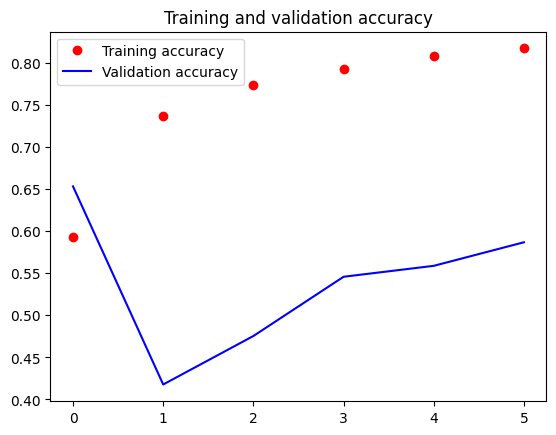

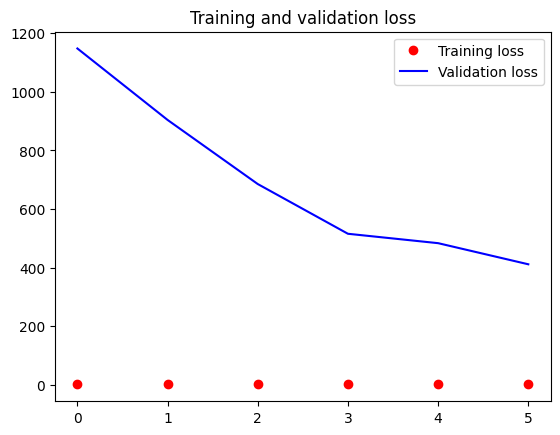

In [ ]:
plot_graph(history)

In [ ]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### Model Evaluation

In [ ]:
classification_report('regularizer_model_2_DO.hdf5')

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 6ms/step
[7 9 0 ... 3 7 0]


### Model 2 with Batch Normalization

In [ ]:
def build_model_l2(l2_loss_lambda):
    """
    builds Keras model with L2 regularization applied to each Conv2D and Dense layers
	@params:
	- l2_loss_lambda: float, controls amount of regularization to apply
	     (optional, default=None)
    """
    
    l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)    
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2, 
               input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu', kernel_regularizer=l2),
        
        Dense(512, activation='relu', kernel_regularizer=l2),
        
        Dense(10, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('regularizer_model_2_DO_BN.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
run_test_harness(build_model_l2(l2_loss_lambda=0.0000010),x_train,y_train)

In [ ]:
history = build_model_l2(l2_loss_lambda=0.0000010).fit(x_train,y_train,
        batch_size=64,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Using L2 regularization - l2_loss_lambda = 0.0000
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_33 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_128 (Conv2D)         (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_34 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
   

#### Visualising model performance

In [ ]:
plot_graph(history)

In [ ]:
plot_accuracy_and_loss(history)

#### model evaluation

In [ ]:
print_classification('regularizer_model_2_DO_BN.hdf5')

# Trying out different optimizers methods
![optimizers](../Images/optimizervisualization.gif)
![optimizers_view](../Images/howoptimizerswork.gif)

In [ ]:
#Get back original x_train,x_test,x_valid
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

(60000, 28, 28, 1)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


In [11]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

## Model 2 with dropout only

In [12]:
def tune_model_2(optimizer):

    activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])


    model.summary()
    return model

In [23]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
history_array = []
for i in optimizers:
    model = tune_model_2(i)
    history = model.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[monitor_val_acc],
          validation_data = (x_valid, y_valid))
    model.save('optimizer_model_2_{}.hdf5'.format(i))
    history_array.append(history)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 5, 5, 64)        

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 5s 15ms/step - loss: 0.7596 - accuracy: 0.7178 - val_loss: 0.4839 - val_accuracy: 0.8204
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4553 - accuracy: 0.8337 - val_loss: 0.3734 - val_accuracy: 0.8658
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.3899 - accuracy: 0.8576 - val_loss: 0.3414 - val_accuracy: 0.8792
Epoch 4/50
235/235 [==============================] - 5s 20ms/step - loss: 0.3471 - accuracy: 0.8746 - val_loss: 0.3209 - val_accuracy: 0.8898
Epoch 5/50
235/235 [==============================] - 4s 17ms/step - loss: 0.3251 - accuracy: 0.8821 - val_loss: 0.3018 - val_accuracy: 0.8938
Epoch 6/50
235/235 [==============================] - 4s 16ms/step - loss: 0.3077 - accuracy: 0.8875 - val_loss: 0.2971 - val_accuracy: 0.8942
Epoch 7/50
235/235 [==============================] - 3s 14ms/step - loss: 0.2960 - accuracy: 0.8917 - val_loss: 0.2804 - val_accuracy: 0.9006
Epoch 8/50

### Visualising model performance

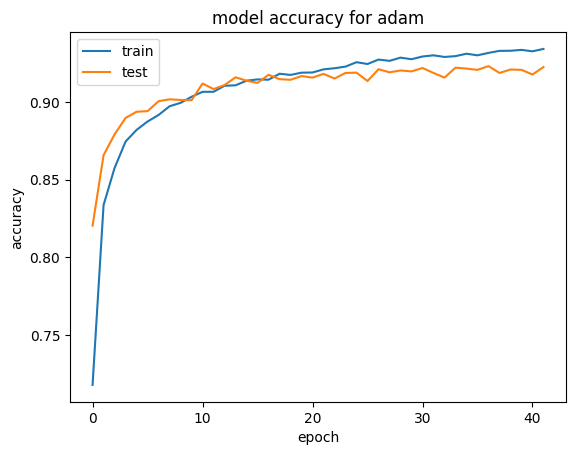

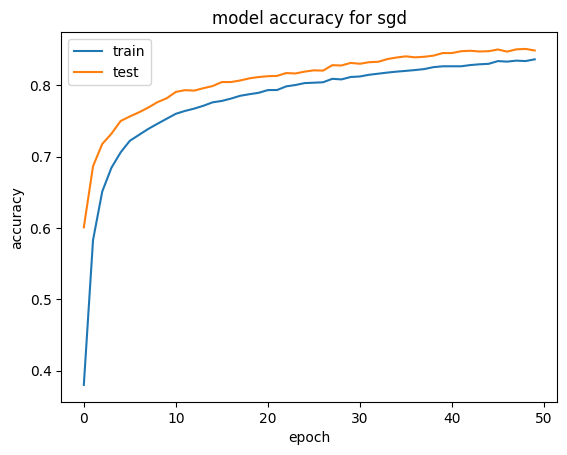

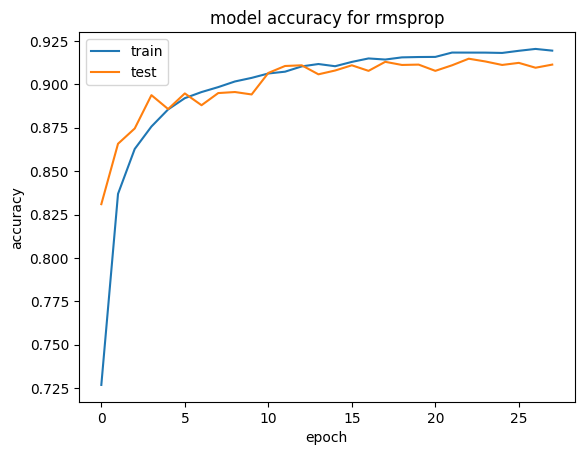

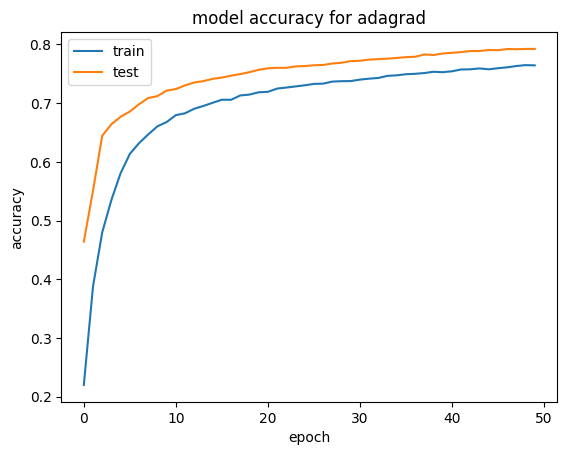

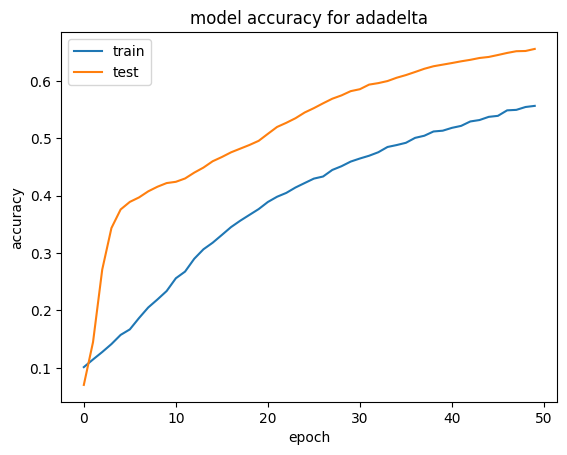

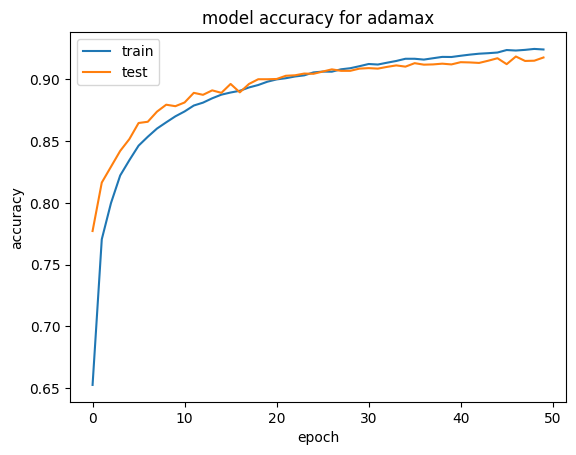

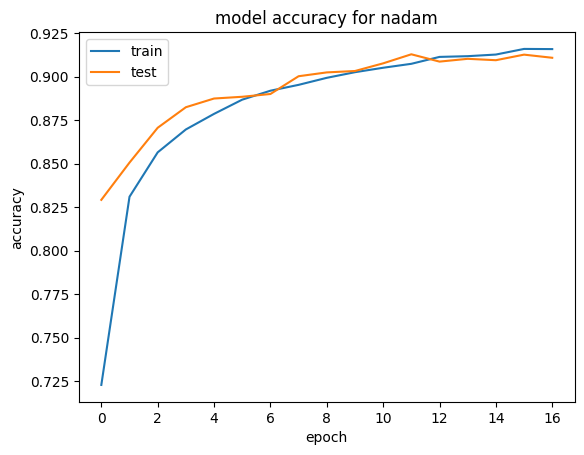

In [24]:
for i in range(len(history_array)):
    model_name = optimizers[i]
    plt.plot(history_array[i].history['accuracy'])
    plt.plot(history_array[i].history['val_accuracy'])
    plt.title(f'model accuracy for {model_name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [41]:
for i in history_array:
    model_name = optimizers[history_array.index(i)]
    print(model_name)
    plot_accuracy_and_loss(i)

adam


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



sgd


rmsprop


adagrad


adadelta


adamax


nadam


### Model evaluation

In [29]:
# plot classification matrix
for i in optimizers:
    print("Classification report for model {}".format(i))
    print_classification('optimizer_model_2_{}.hdf5'.format(i))
    print()
    print()


Classification report for model adam
  9/157 [>.............................] - ETA: 0s - loss: 0.1917 - accuracy: 0.9201 

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 4ms/step
[6 0 8 ... 3 4 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.78      0.92      0.84       486
    Item Trouser 1       1.00      0.99      0.99       504
   Item Pullover 2       0.88      0.90      0.89       492
      Item Dress 3       0.95      0.93      0.94       499
       Item Coat 4       0.89      0.89      0.89       512
     Item Sandal 5       0.99      1.00      0.99       485
      Item Shirt 6       0.86      0.72      0.79       495
    Item Sneaker 7       0.94      0.98      0.96       505
        Item Bag 8       0.98      0.98      0.98       511
 Item Ankle Boot 9       0.99      0.95      0.97       511

          accuracy                           0.93      5000
         macro avg       0.93      0.93      0.92      5000
      weighted avg       0.93      0.93      0.93      5000



Classification report for model sgd
  1/157 [..............................] - ETA

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 4ms/step
[6 0 8 ... 3 4 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.49      0.87      0.62       486
    Item Trouser 1       0.99      0.97      0.98       504
   Item Pullover 2       0.86      0.60      0.71       492
      Item Dress 3       0.91      0.84      0.87       499
       Item Coat 4       0.76      0.75      0.75       512
     Item Sandal 5       0.98      0.96      0.97       485
      Item Shirt 6       0.70      0.50      0.59       495
    Item Sneaker 7       0.93      0.94      0.93       505
        Item Bag 8       0.98      0.92      0.95       511
 Item Ankle Boot 9       0.95      0.95      0.95       511

          accuracy                           0.83      5000
         macro avg       0.86      0.83      0.83      5000
      weighted avg       0.86      0.83      0.83      5000



Classification report for model rmsprop
  1/157 [..............................] -

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 3ms/step
[6 0 8 ... 3 4 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.65      0.93      0.77       486
    Item Trouser 1       1.00      0.99      0.99       504
   Item Pullover 2       0.87      0.89      0.88       492
      Item Dress 3       0.95      0.88      0.92       499
       Item Coat 4       0.91      0.81      0.85       512
     Item Sandal 5       0.99      0.98      0.99       485
      Item Shirt 6       0.84      0.66      0.74       495
    Item Sneaker 7       0.96      0.97      0.97       505
        Item Bag 8       0.99      0.98      0.98       511
 Item Ankle Boot 9       0.96      0.97      0.97       511

          accuracy                           0.91      5000
         macro avg       0.91      0.90      0.91      5000
      weighted avg       0.91      0.91      0.91      5000



Classification report for model adagrad
  1/157 [..............................] -

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 4ms/step
[0 0 8 ... 3 4 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.29      0.93      0.44       486
    Item Trouser 1       0.99      0.94      0.96       504
   Item Pullover 2       0.79      0.26      0.39       492
      Item Dress 3       0.85      0.82      0.83       499
       Item Coat 4       0.71      0.51      0.59       512
     Item Sandal 5       0.96      0.92      0.94       485
      Item Shirt 6       0.50      0.01      0.01       495
    Item Sneaker 7       0.91      0.90      0.91       505
        Item Bag 8       0.96      0.88      0.92       511
 Item Ankle Boot 9       0.93      0.95      0.94       511

          accuracy                           0.71      5000
         macro avg       0.79      0.71      0.69      5000
      weighted avg       0.79      0.71      0.70      5000



Classification report for model adadelta
  1/157 [..............................] 

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 4ms/step
[0 0 8 ... 0 0 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.17      0.99      0.29       486
    Item Trouser 1       0.97      0.82      0.89       504
   Item Pullover 2       0.00      0.00      0.00       492
      Item Dress 3       0.97      0.33      0.49       499
       Item Coat 4       0.80      0.02      0.05       512
     Item Sandal 5       0.98      0.51      0.67       485
      Item Shirt 6       0.00      0.00      0.00       495
    Item Sneaker 7       0.78      0.82      0.80       505
        Item Bag 8       0.98      0.40      0.57       511
 Item Ankle Boot 9       0.88      0.89      0.88       511

          accuracy                           0.48      5000
         macro avg       0.65      0.48      0.46      5000
      weighted avg       0.66      0.48      0.47      5000



Classification report for model adamax


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



  1/157 [..............................] - ETA: 38s - loss: 0.0978 - accuracy: 0.9688

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 3ms/step
[6 0 8 ... 3 4 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.76      0.91      0.82       486
    Item Trouser 1       0.99      0.99      0.99       504
   Item Pullover 2       0.90      0.89      0.90       492
      Item Dress 3       0.94      0.92      0.93       499
       Item Coat 4       0.89      0.88      0.89       512
     Item Sandal 5       0.99      0.99      0.99       485
      Item Shirt 6       0.84      0.74      0.79       495
    Item Sneaker 7       0.96      0.97      0.97       505
        Item Bag 8       0.99      0.97      0.98       511
 Item Ankle Boot 9       0.98      0.97      0.97       511

          accuracy                           0.92      5000
         macro avg       0.92      0.92      0.92      5000
      weighted avg       0.92      0.92      0.92      5000



Classification report for model nadam
  1/157 [..............................] - E

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 4ms/step
[6 0 8 ... 3 4 1]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.75      0.88      0.81       486
    Item Trouser 1       1.00      0.98      0.99       504
   Item Pullover 2       0.92      0.82      0.87       492
      Item Dress 3       0.95      0.92      0.93       499
       Item Coat 4       0.86      0.91      0.89       512
     Item Sandal 5       0.98      0.99      0.99       485
      Item Shirt 6       0.77      0.72      0.75       495
    Item Sneaker 7       0.97      0.97      0.97       505
        Item Bag 8       0.98      0.97      0.98       511
 Item Ankle Boot 9       0.98      0.97      0.97       511

          accuracy                           0.91      5000
         macro avg       0.92      0.91      0.91      5000
      weighted avg       0.92      0.91      0.92      5000





## Model 2 with batch normalization

In [14]:
def tune_model_2(optimizer):

    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer=optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [15]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
history_array = []
for i in optimizers:
    model = tune_model_2(i)
    history = model.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[monitor_val_acc],
          validation_data = (x_valid, y_valid))
    model.save('optimizer_model_2_DO_BN_{}.hdf5'.format(i))
    history_array.append(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 24)        6936      
                                                        

Visualising model performance

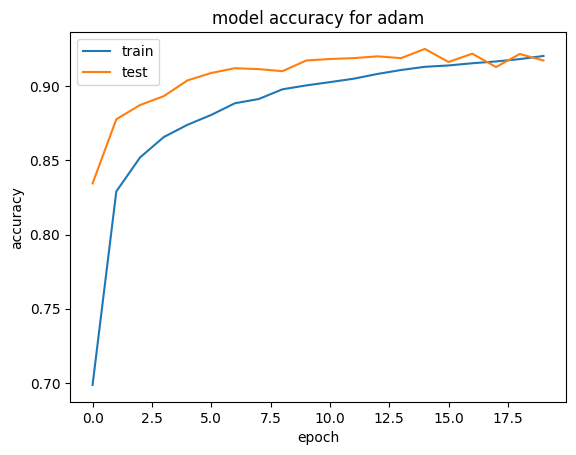

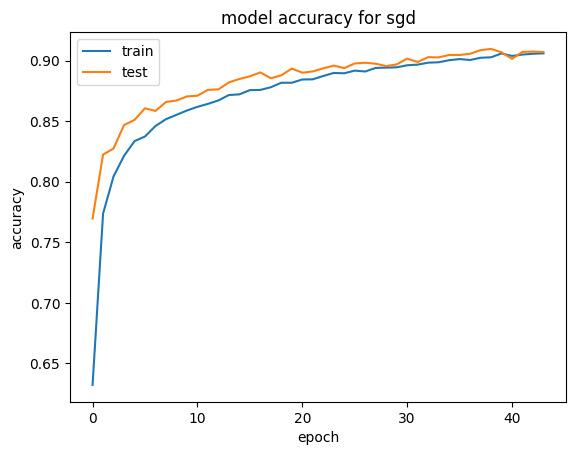

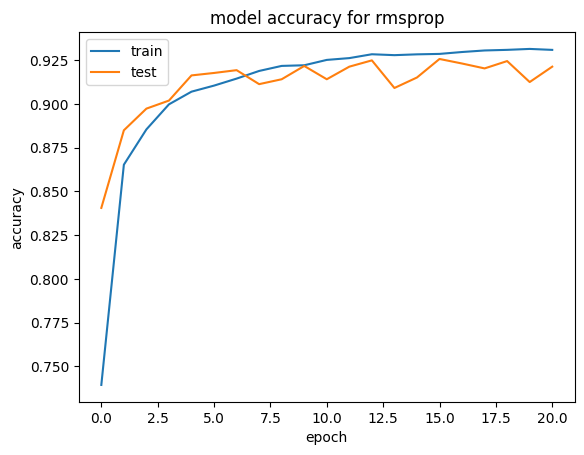

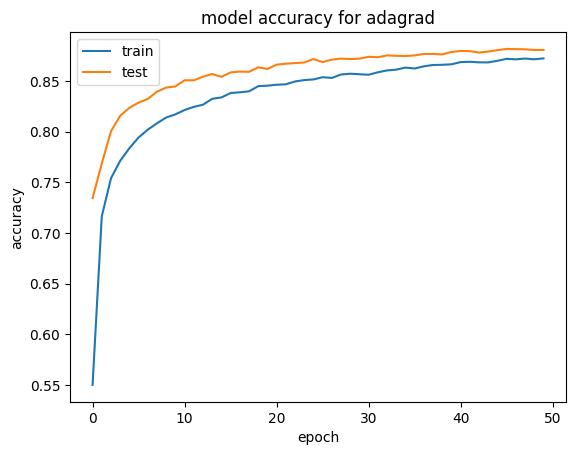

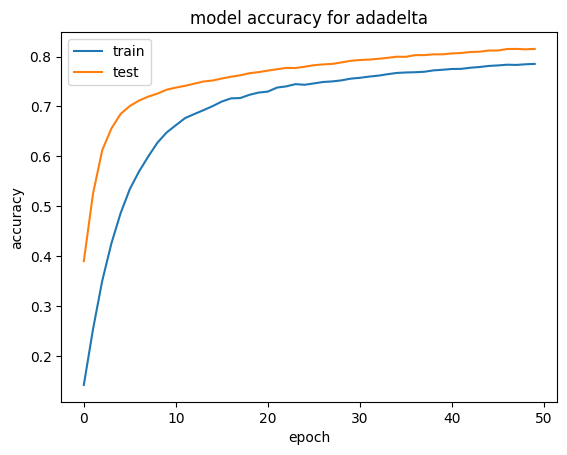

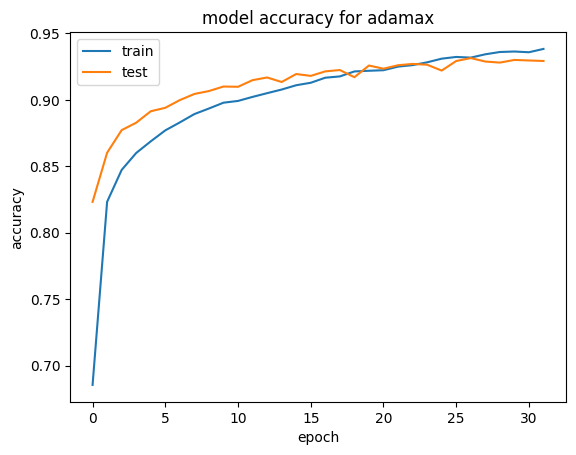

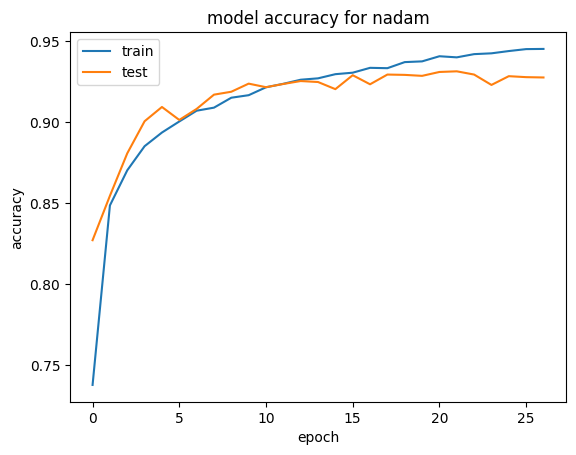

In [16]:
for i in range(len(history_array)):
    model_name = optimizers[i]
    plt.plot(history_array[i].history['accuracy'])
    plt.plot(history_array[i].history['val_accuracy'])
    plt.title(f'model accuracy for {model_name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

evaluating model

In [17]:
# plot classification matrix
for i in optimizers:
    print("Classification report for model {}".format(i))
    print_classification('optimizer_model_2_DO_BN_{}.hdf5'.format(i))
    print()
    print()


Classification report for model adam
157/157 [==============================] - 1s 6ms/step
[0 0 0 ... 4 7 4]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.72      0.90      0.80       503
    Item Trouser 1       0.99      0.99      0.99       499
   Item Pullover 2       0.79      0.92      0.85       506
      Item Dress 3       0.96      0.93      0.95       498
       Item Coat 4       0.90      0.79      0.84       502
     Item Sandal 5       0.99      0.97      0.98       494
      Item Shirt 6       0.86      0.63      0.73       508
    Item Sneaker 7       0.96      0.98      0.97       519
        Item Bag 8       0.99      0.98      0.98       465
 Item Ankle Boot 9       0.97      0.97      0.97       506

          accuracy                           0.91      5000
         macro avg       0.91      0.91      0.91      5000
      weighted avg       0.91      0.91      0.91      5000



Classification report for model sgd
157/157 [

# Padding/Without padding
adds black pixels to the edges

In [9]:
def pad_model_2(pad):
    model_2 = Sequential()
    model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1),padding=pad))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding=pad))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding=pad))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding=pad))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [10]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [11]:
padding = ['valid','same']
history_array = []
for i in padding:
    model = pad_model_2(i)
    history = model.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[monitor_val_acc],
          validation_data = (x_valid, y_valid))
    model.save('padding_model_2_DO_BN_{}.hdf5'.format(i))
    history_array.append(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 26, 26, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 24)        6936      
                                                        

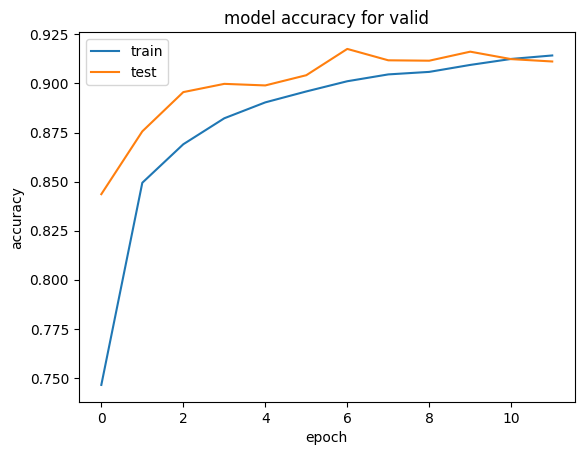

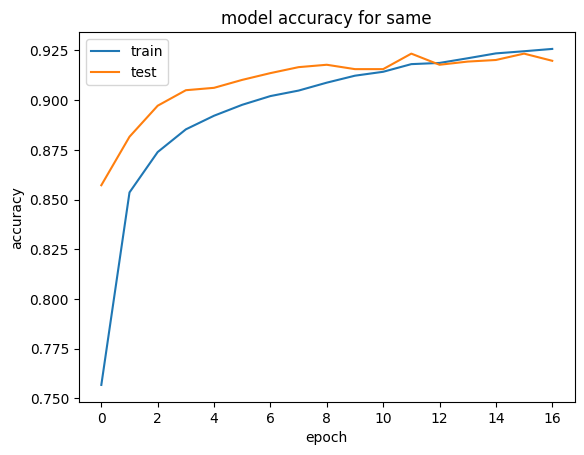

In [13]:
for i in range(len(history_array)):
    model_name = padding[i]
    plt.plot(history_array[i].history['accuracy'])
    plt.plot(history_array[i].history['val_accuracy'])
    plt.title(f'model accuracy for {model_name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [17]:
for i in history_array:
    model_name = padding[history_array.index(i)]
    print(model_name)
    plot_accuracy_and_loss(i)

valid


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



same


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [21]:
for i in padding: 
    print('Padding style {}'.format(i))
    print_classification(f'padding_model_2_DO_BN_{i}.hdf5')

Padding style valid
157/157 [==============================] - 1s 5ms/step
[1 0 6 ... 0 0 7]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.67      0.92      0.78       476
    Item Trouser 1       1.00      0.98      0.99       498
   Item Pullover 2       0.83      0.90      0.86       515
      Item Dress 3       0.93      0.89      0.91       506
       Item Coat 4       0.91      0.75      0.82       503
     Item Sandal 5       0.98      0.98      0.98       526
      Item Shirt 6       0.82      0.66      0.73       486
    Item Sneaker 7       0.98      0.97      0.97       504
        Item Bag 8       0.99      0.99      0.99       493
 Item Ankle Boot 9       0.97      0.98      0.97       493

          accuracy                           0.90      5000
         macro avg       0.91      0.90      0.90      5000
      weighted avg       0.91      0.90      0.90      5000

Padding style same
157/157 [==============================] - 1s

# Autoencoding

In [61]:
#load data
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pandas as pd
import numpy as np

def make_and_fit():
    inputs = Input(shape=(28, 28, 1))
    x = (Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))(inputs)
    x = (BatchNormalization())(x)
    x = (Dropout(0.2))(x)
    x = (Conv2D(32, kernel_size=3, activation='relu',padding='same'))(x)
    x = (Dropout(0.2))(x)
    x = (Conv2D(24, kernel_size=3, activation='relu',padding='same'))(x)
    x = (Dropout(0.4))(x)
    x = (Conv2D(64, kernel_size=3, activation='relu',padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2,2)))(x)
    x = (Dropout(0.3))(x)
    x = (Flatten())(x)
    x = (Dense(128, activation='relu'))(x)
    x = (Dropout(0.3))(x)
    x = (Dense(10, activation='softmax'))(x)
    
    encoded = Dense(10, activation='relu')(x)
    

    encoder = Model(inputs=inputs, outputs=encoded)
    
    encoded_inputs = Input(shape=(10,))

    x = Dense(16, activation='relu')(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = (Dropout(0.2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='softmax', padding='same')(x)

    decoder = Model(inputs=encoded_inputs, outputs=decoded)
    
    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

    print(model.summary())
    
    clr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

    model.fit(
        x_train,
        x_train,
        batch_size=256,
        epochs=50,
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[clr])

    return model, encoder, decoder

model, encoder, decoder = make_and_fit()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 model_32 (Functional)       (None, 10)                1637680   
                                                                 
 model_33 (Functional)       (None, 28, 28, 1)         42449     
                                                                 
Total params: 1,680,129
Trainable params: 1,679,969
Non-trainable params: 160
_________________________________________________________________
None
Epoch 1/50
235/235 [==============================] - 22s 62ms/step - loss: 0.4954 - accuracy: 0.0081 - mse: 0.6344 - val_loss: 10.8750 - val_accuracy: 0.0080 - val_mse: 0.6328 - lr: 0.0010
Epoch 2/50
 99/235 [===========>..................] - ETA: 7s - loss: 0.4919 - accuracy: 0.0080 - mse: 0.6337

KeyboardInterrupt: 

313/313 [==============================] - 1s 4ms/step


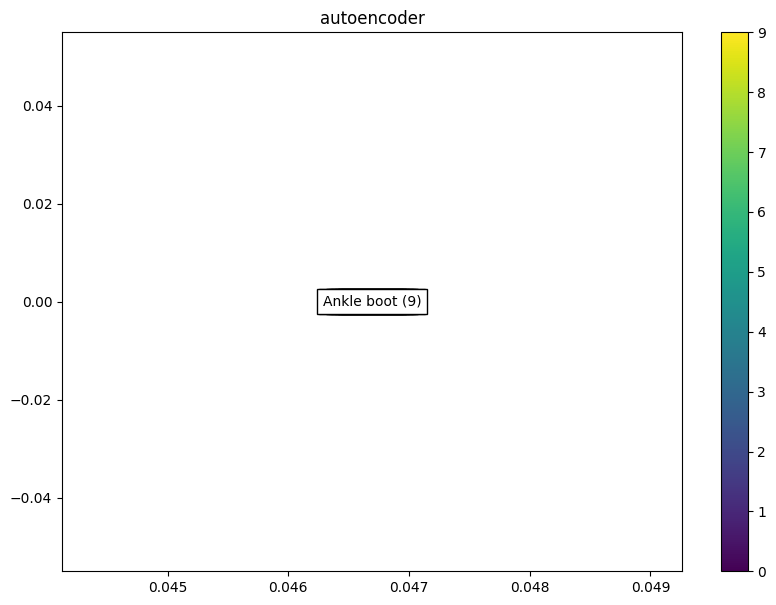

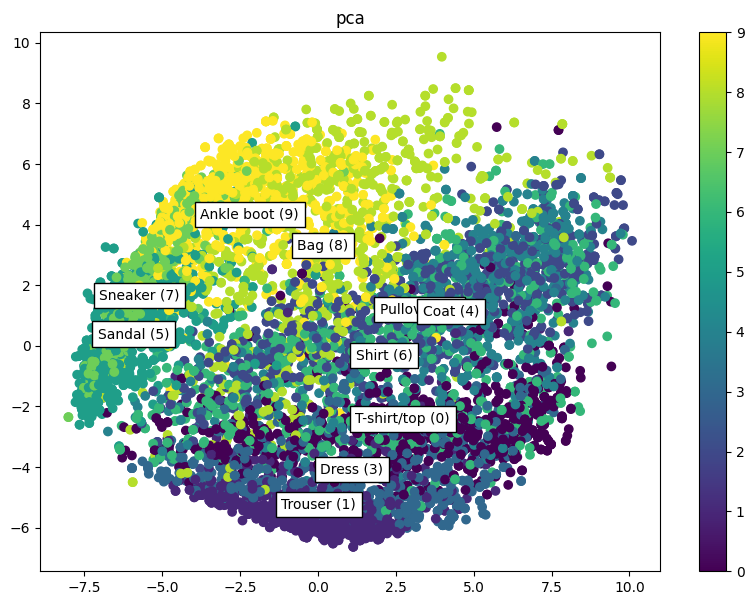

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



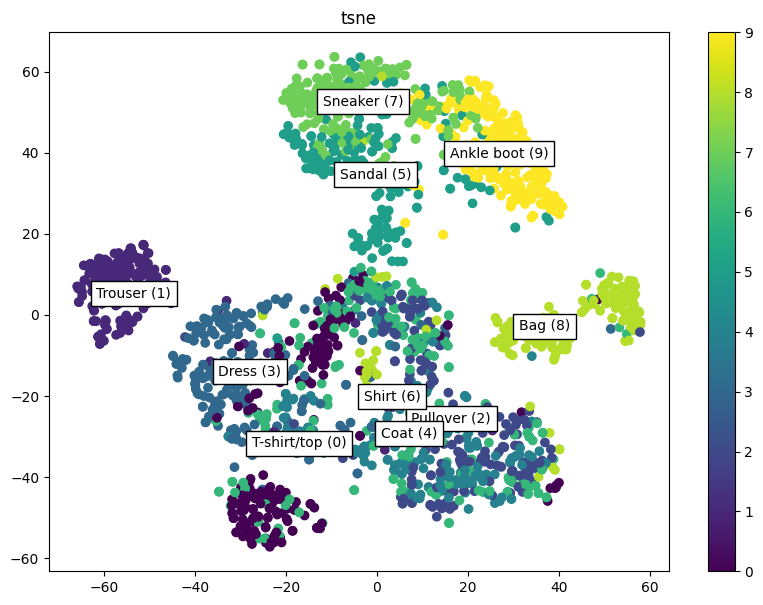

10/10 [==============================] - 0s 25ms/step


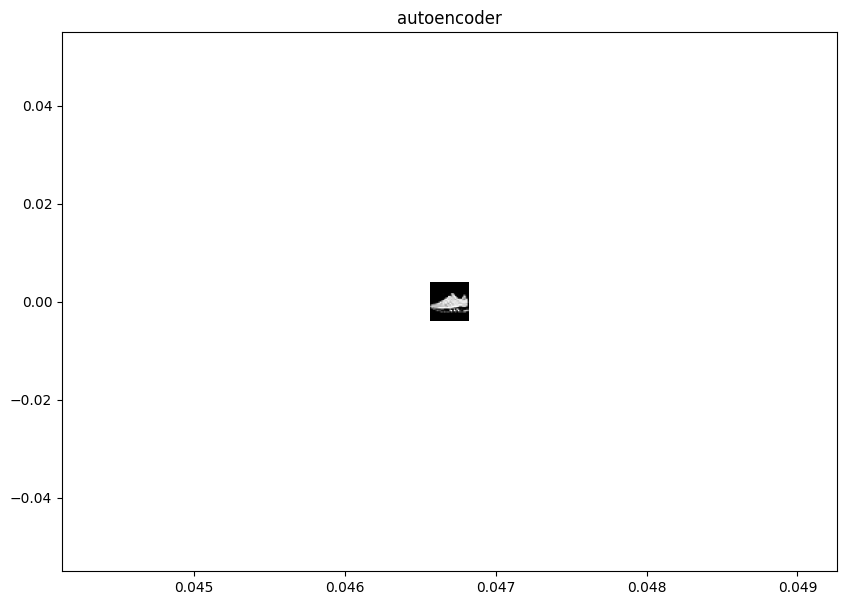

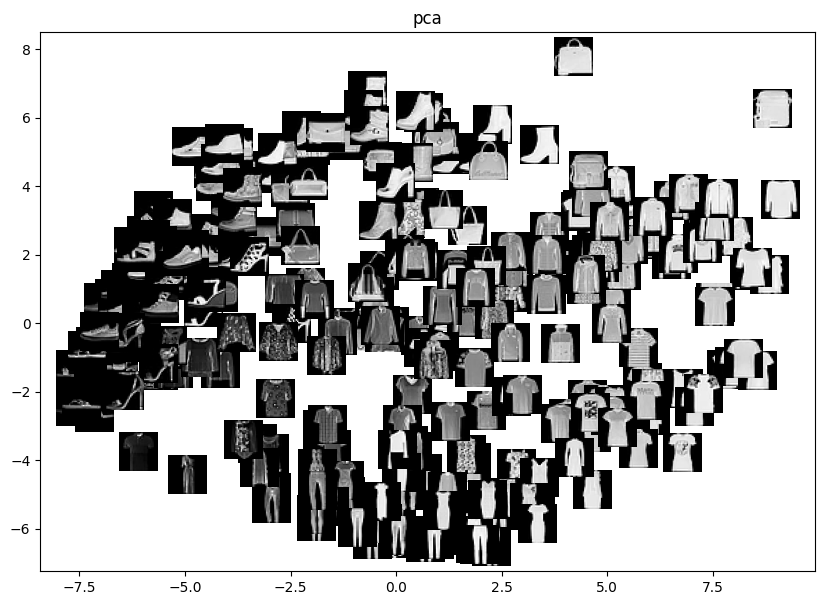

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



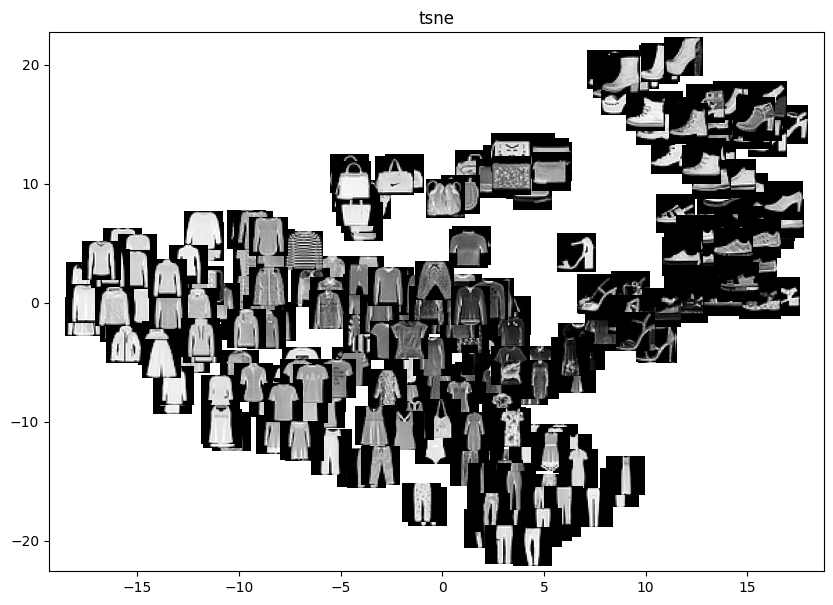

In [48]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent(mode, count, technique):
    labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'autoencoder')
plot_latent('dots', 10000, 'pca')
plot_latent('dots', 2000, 'tsne')

plot_latent('imgs', 300, 'autoencoder')
plot_latent('imgs', 300, 'pca')
plot_latent('imgs', 300, 'tsne')

# Final Model 2 

## Best optimizer - Adamax

Data augmentation

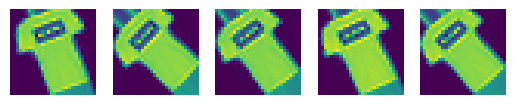

In [18]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,  
    zca_whitening=False,
    rotation_range=50,
    width_shift_range=0.01, 
    height_shift_range=0.01, 
    horizontal_flip=False, 
    vertical_flip=False)

datagen.fit(x_train)

from matplotlib import pyplot as plt

gen = datagen.flow(x_train[1:2], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

Using best batch normalization and dropout model

In [24]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adamax', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [28]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('Best_model_adamax.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_14 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 24)        6936      
                                                      

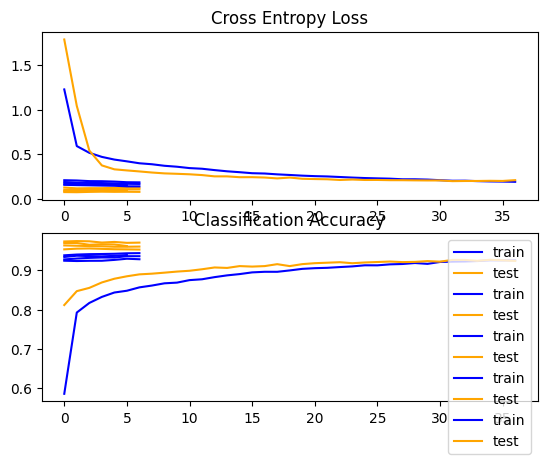

Accuracy: mean=95.407 std=1.605, n=5


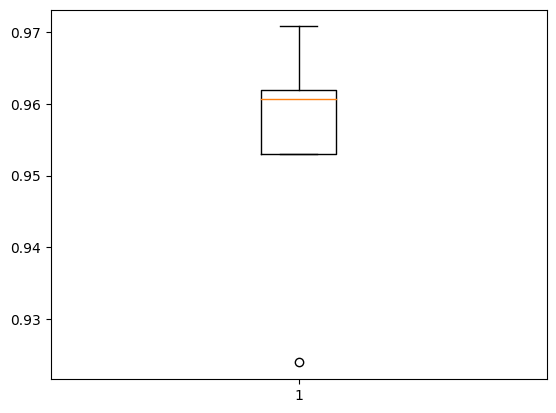

In [25]:
run_test_harness(model_2_create(), x_train,y_train)

In [29]:
history = model_2_create().fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_40 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 dropout_41 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 24)        6936      
                                                      

Test loss: 0.19282566010951996
Test accuracy: 0.932200014591217


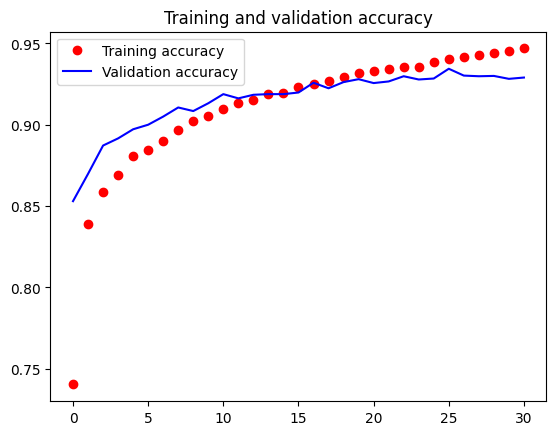

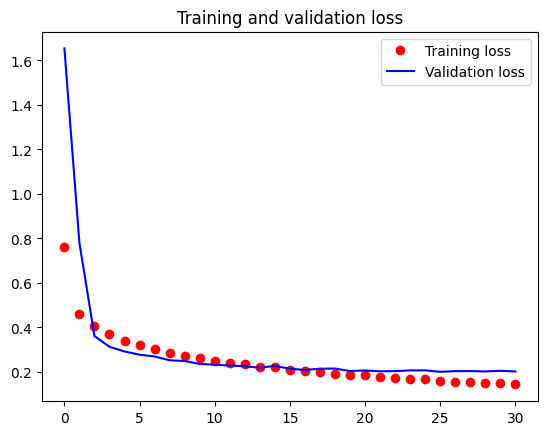

In [30]:
plot_graph(history)

In [31]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [25]:
print_classification('Best_model_adamax.hdf5')

157/157 [==============================] - 1s 6ms/step
[6 0 0 ... 4 7 4]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.81      0.90      0.85       503
    Item Trouser 1       1.00      0.99      0.99       499
   Item Pullover 2       0.93      0.90      0.91       506
      Item Dress 3       0.95      0.94      0.94       498
       Item Coat 4       0.87      0.90      0.89       502
     Item Sandal 5       0.98      0.99      0.98       494
      Item Shirt 6       0.85      0.78      0.81       508
    Item Sneaker 7       0.97      0.98      0.97       519
        Item Bag 8       0.99      0.97      0.98       465
 Item Ankle Boot 9       0.98      0.96      0.97       506

          accuracy                           0.93      5000
         macro avg       0.93      0.93      0.93      5000
      weighted avg       0.93      0.93      0.93      5000



## Best optimizer - nadam

In [26]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='nadam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [32]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('Best_model_nadam.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_19 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 24)        6936      
                                                      

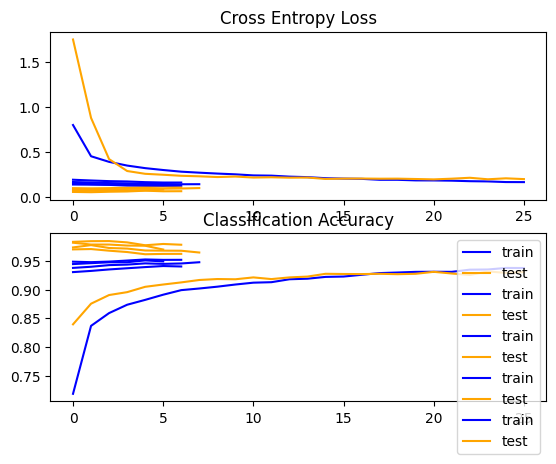

Accuracy: mean=96.085 std=1.608, n=5


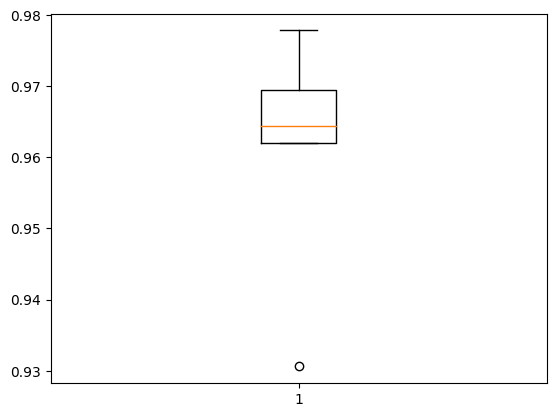

In [27]:
run_test_harness(model_2_create(), x_train,y_train)

In [33]:
history = model_2_create().fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_45 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 dropout_46 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 24)        6936      
                                                      

Test loss: 0.18969911336898804
Test accuracy: 0.9323999881744385


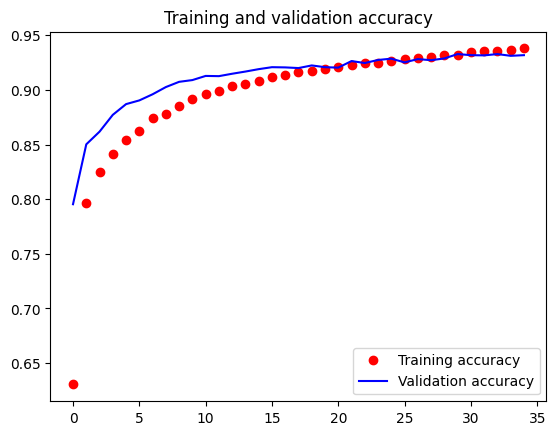

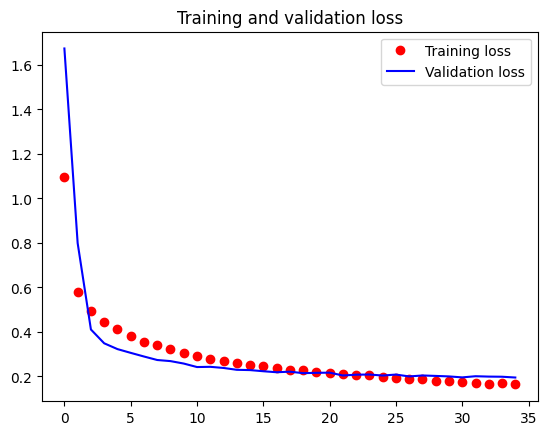

In [34]:
plot_graph(history)

In [35]:
plot_accuracy_and_loss(history)

In [36]:
print_classification('Best_model_nadam.hdf5')

157/157 [==============================] - 1s 4ms/step
[0 6 0 ... 4 7 4]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.80      0.93      0.86       503
    Item Trouser 1       0.99      0.99      0.99       499
   Item Pullover 2       0.93      0.89      0.91       506
      Item Dress 3       0.94      0.94      0.94       498
       Item Coat 4       0.87      0.90      0.89       502
     Item Sandal 5       0.98      0.98      0.98       494
      Item Shirt 6       0.86      0.74      0.80       508
    Item Sneaker 7       0.95      0.98      0.97       519
        Item Bag 8       0.99      0.98      0.99       465
 Item Ankle Boot 9       0.99      0.96      0.97       506

          accuracy                           0.93      5000
         macro avg       0.93      0.93      0.93      5000
      weighted avg       0.93      0.93      0.93      5000



# Trying out Model 3 - VGG

What have i not tried
<li>
use a constant seed value

# Conclusion: